In [353]:
from os import listdir
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import catboost as cb
from sklearn.ensemble import ExtraTreesClassifier

from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate

warnings.filterwarnings(action='ignore')

plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)

In [401]:
def correlation_extract(df, threshold):
    cor_df = df.corr()
    col_list = cor_df.columns
    
    for idx, col in enumerate(col_list):
        idx_ls = cor_df[abs(cor_df[col])>=threshold].index.tolist()
        print(f'{col} : {idx_ls}')
def col_extract(df):
    col_ls = []
    for col in df.columns.tolist():
        if col[0] == 'Q' and col[-1] == 'E':
            col_ls.append(col)
            
    return col_ls

In [354]:
model_path = './modeling_folder'
data_file_path = './open data'

In [355]:
tr = pd.read_csv(os.path.join(model_path,'train_data.csv'))
te = pd.read_csv(os.path.join(model_path,'test_data.csv'))

In [357]:
# modeling_file_ls = []
# for file in os.listdir(model_path):
#     if 'modeling' in file:
#         modeling_file_ls.append(file)

# ver_num_ls = []
# for file in modeling_file_ls:
#     ver_num_ls.append(re.sub('[^0-9]','',file))

# ver_num = int(pd.Series(list(set(ver_num_ls))).sort_values(ascending=False).iloc[0])
ver_num =  1

base_tr = pd.read_csv(os.path.join(data_file_path,'train.csv'))
tr = pd.read_csv(
    os.path.join(model_path,'modeling_tr_ver{}.csv'.format(ver_num))
)
te = pd.read_csv(
    os.path.join(model_path,'modeling_te_ver{}.csv'.format(ver_num))
)

base_column = base_tr.drop(columns = 'index').columns.tolist()
submission = te[['index']]

tr.drop(columns = 'index',inplace = True)
te.drop(columns = 'index', inplace = True)

In [395]:
# 변수 체크
tr.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13',
       'Q_E_sum', 'Q_E_median', 'education_ft1', 'education_ft2',
       'married_value', 'age_group_value', 'wr_sum', 'wf_sum', 'wr_wf_sum'],
      dtype='object')

# Model training

## LGBM Modeling code

In [438]:
def validation_model(df,base_column):
    plus_col = list(set(df.columns.tolist()) - set(base_column))
    except_col = list(set(base_column) - set(df.columns.tolist()))
    print(f'추가변수 : {plus_col}')
    print(f'제외변수 : {except_col}')
    X_train, X_test, y_train, y_test = train_test_split(
                                df.drop(columns = 'voted'),df['voted'],
                                random_state = 0,
                                test_size = 0.2
                            )
    
    folds = StratifiedKFold(n_splits=5, shuffle = True, random_state = 111)
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    feature_importance = pd.DataFrame()
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):
        
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

#       'bagging_fraction': 0.5174586752499394,
#       'colsample_bytree': 0.16336591285805346,
#       'feature_fraction': 0.6600295087430476,
#       'lambda_l1': 0.5045786221433113,
#       'lambda_l2': 0.34677843618253623,
#       'learning_rate': 0.008679434863557151,
#       'max_depth': 5.05906487896959,
#       'min_child_weight': 35.46747545288431,
#       'num_leaves': 532.5547433920851
     
    # 성능이 좋은 베이지안 파라미터
#      bagging_fraction = 0.9669958011996147,
#             colsample_bytree = 0.5987970645475955, # 0.78
#             feature_fraction = 0.7318970172463788,
#             lambda_l1 = 0.03879591433177747,
#             lambda_l2 = 0.2799788929506455,
#             learning_rate = 0.006097808404537128, # 0.011
#             max_depth = 9,
#             min_child_weight = 38,
#             num_leaves = 395,

# 로그화
# bagging_fraction = 0.16026521886490075,
# colsample_bytree = 0.38230762664460116,
# feature_fraction = 0.8803127292536881,
# lambda_l1 = 0.6427909607958205,
# lambda_l2 = 0.8516225399539507,
# learning_rate = 0.004810297234567945,
# max_depth = 6.072081164468878,
# min_child_weight = 30.470923513342353,
# num_leaves = 570.2124396849822,

        clf = lgb.LGBMClassifier(
            n_estimators=1000,
            objective='binary',
            boosting_type='gbdt', # gbdt
            bagging_fraction = 0.16026521886490075,
            colsample_bytree = 0.38230762664460116,
            feature_fraction = 0.8803127292536881,
            lambda_l1 = 0.6427909607958205,
            lambda_l2 = 0.8516225399539507,
            learning_rate = 0.004810297234567945,
            max_depth = 6,
            min_child_weight = 30,
            num_leaves = 570,
            random_state= 200,
        )
        
        clf.fit(
            train_x, train_y,
            eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', 
            verbose= 100, 
            early_stopping_rounds=300,
        )
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, best_iteration_ = clf.best_iteration_)[:,1]
        test_preds += clf.predict_proba(X_test, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits 
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_train.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
    ft = feature_importance.groupby('feature')['importance'].mean().reset_index()

    ft2 = ft.sort_values('importance',ascending = False).iloc[:50]
    
    feature_graph_df = feature_importance.sort_values('importance')
    plt.figure(figsize = (16,12))
    plt.barh(ft2['feature'],ft2['importance'])
    
    final_score = roc_auc_score(y_test,test_preds)
    print('\n\n')
    print('================================================')
    print(f'\n최종성능: {final_score}\n')
    print('================================================')
    return ft, test_preds, y_test

### LGBM training

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.78289	training's binary_logloss: 0.574109	valid_1's auc: 0.764767	valid_1's binary_logloss: 0.580744
[200]	training's auc: 0.792487	training's binary_logloss: 0.547565	valid_1's auc: 0.768189	valid_1's binary_logloss: 0.561352
[300]	training's auc: 0.801067	training's binary_logloss: 0.53629	valid_1's auc: 0.769862	valid_1's binary_logloss: 0.556635
[400]	training's auc: 0.810524	training's binary_logloss: 0.527509	valid_1's auc: 0.770975	valid_1's binary_logloss: 0.554996
[500]	training's auc: 0.820598	training's binary_logloss: 0.519245	valid_1's auc: 0.770863	valid_1's binary_logloss: 0.554851
[600]	training's auc: 0.828807	training's binary_logloss: 0.512388	valid_1's auc: 0.770622	valid_1's binary_logloss: 0.555016
[700]	training's auc: 0.836383	trainin

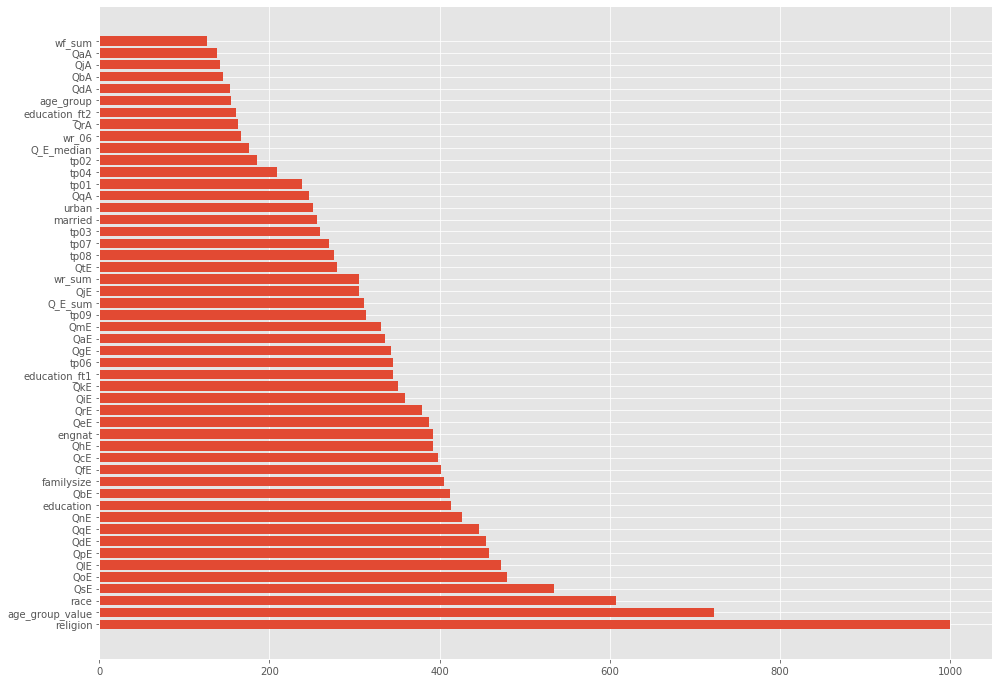

In [562]:
ft, test_preds, y_test = validation_model(tr,base_column)

### LGBM 변수소거 테스트

추가변수 : ['married_value', 'wf_sum', 'Q_E_sum', 'wr_sum', 'age_group_value', 'education_ft2', 'education_ft1', 'wr_wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.805636	training's binary_logloss: 0.599272	valid_1's auc: 0.767138	valid_1's binary_logloss: 0.609109
[200]	training's auc: 0.815946	training's binary_logloss: 0.558886	valid_1's auc: 0.767858	valid_1's binary_logloss: 0.578682
[300]	training's auc: 0.825591	training's binary_logloss: 0.536263	valid_1's auc: 0.767607	valid_1's binary_logloss: 0.56595
[400]	training's auc: 0.832171	training's binary_logloss: 0.522774	valid_1's auc: 0.768334	valid_1's binary_logloss: 0.56015
[500]	training's auc: 0.839476	training's binary_logloss: 0.512845	valid_1's auc: 0.769233	valid_1's binary_logloss: 0.557443
[600]	training's auc: 0.846595	training's binary_logloss: 0.504659	valid_1's auc: 0.769475	valid_1's binary_logloss: 0.556298
[700]	training's auc: 0.852766	trainin

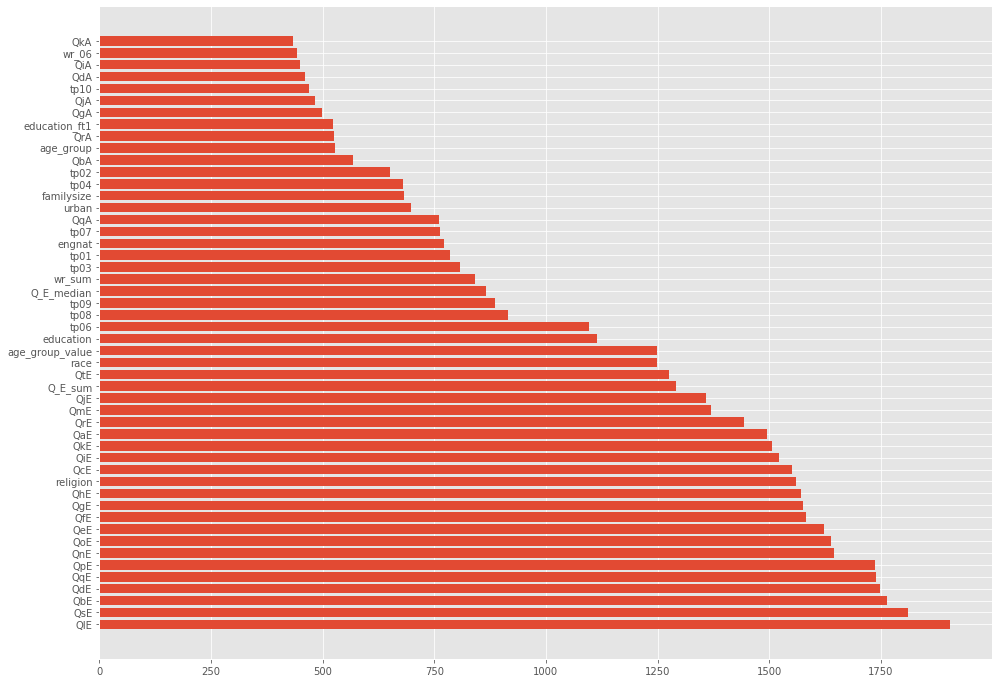

In [360]:
# 모든 변수 포함
ft, test_preds, y_test = validation_model(tr,base_column)

In [380]:
# 다중공선성 여부 체크 후 변수소거법
correlation_extract(tr,0.7)

QaA : ['QaA']
QaE : ['QaE']
QbA : ['QbA']
QbE : ['QbE']
QcA : ['QcA']
QcE : ['QcE']
QdA : ['QdA']
QdE : ['QdE']
QeA : ['QeA']
QeE : ['QeE']
QfA : ['QfA']
QfE : ['QfE']
QgA : ['QgA']
QgE : ['QgE']
QhA : ['QhA']
QhE : ['QhE', 'Q_E_sum']
QiA : ['QiA']
QiE : ['QiE']
QjA : ['QjA']
QjE : ['QjE']
QkA : ['QkA']
QkE : ['QkE']
QlA : ['QlA']
QlE : ['QlE']
QmA : ['QmA']
QmE : ['QmE']
QnA : ['QnA']
QnE : ['QnE']
QoA : ['QoA']
QoE : ['QoE']
QpA : ['QpA']
QpE : ['QpE']
QqA : ['QqA']
QqE : ['QqE']
QrA : ['QrA']
QrE : ['QrE']
QsA : ['QsA']
QsE : ['QsE']
QtA : ['QtA']
QtE : ['QtE']
age_group : ['age_group', 'age_group_value']
education : ['education', 'education_ft2']
engnat : ['engnat']
familysize : ['familysize']
gender : ['gender']
hand : ['hand']
married : ['married', 'married_value']
race : ['race']
religion : ['religion']
tp01 : ['tp01']
tp02 : ['tp02']
tp03 : ['tp03']
tp04 : ['tp04']
tp05 : ['tp05']
tp06 : ['tp06']
tp07 : ['tp07']
tp08 : ['tp08']
tp09 : ['tp09']
tp10 : ['tp10']
urban : ['urban']


추가변수 : ['married_value', 'wf_sum', 'Q_E_sum', 'wr_sum', 'age_group_value', 'education_ft2', 'education_ft1', 'wr_wf_sum', 'Q_E_median']
제외변수 : ['wf_02', 'wf_03']
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.771392	training's binary_logloss: 0.593917	valid_1's auc: 0.765986	valid_1's binary_logloss: 0.595499
[200]	training's auc: 0.776976	training's binary_logloss: 0.565693	valid_1's auc: 0.766751	valid_1's binary_logloss: 0.570465
[300]	training's auc: 0.780656	training's binary_logloss: 0.554263	valid_1's auc: 0.767735	valid_1's binary_logloss: 0.561776
[400]	training's auc: 0.785053	training's binary_logloss: 0.547902	valid_1's auc: 0.768867	valid_1's binary_logloss: 0.558391
[500]	training's auc: 0.789991	training's binary_logloss: 0.543173	valid_1's auc: 0.769707	valid_1's binary_logloss: 0.556983
[600]	training's auc: 0.795659	training's binary_logloss: 0.538669	valid_1's auc: 0.770001	valid_1's binary_logloss: 0.556397
[700]	training's auc

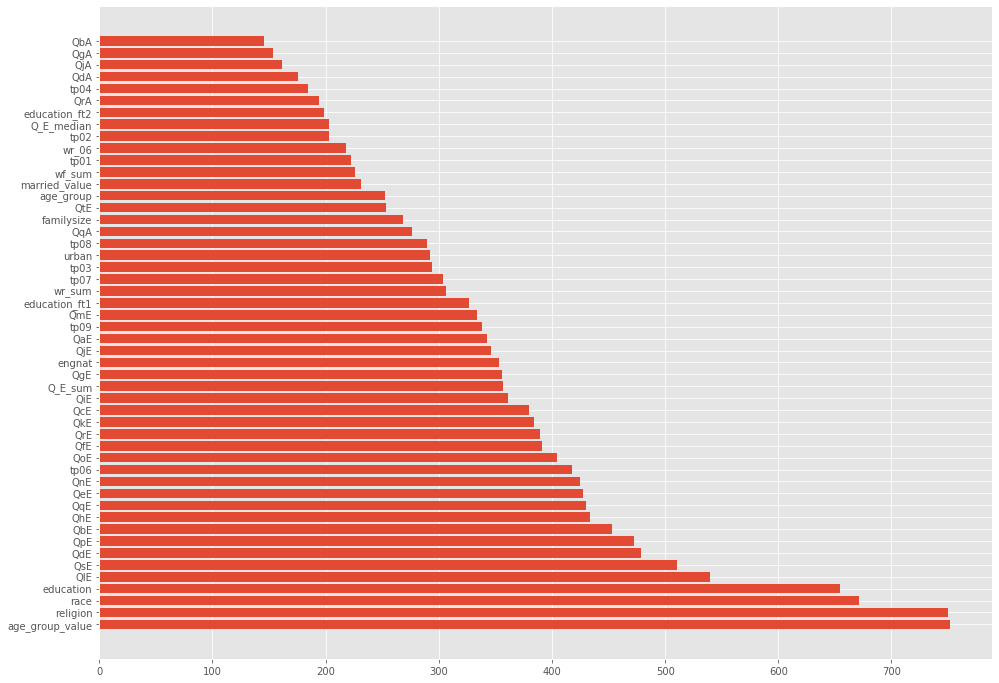

In [390]:
# 모든 변수 포함
ft, test_preds, y_test = validation_model(
    tr.drop(
        columns = [
            'wf_03',
            'wf_02'
        ]
    ),
    base_column
)

추가변수 : ['QfE_log', 'QnE_log', 'QmE_log', 'QhE_log', 'age_group_value', 'QlE_log', 'QrE_log', 'QeE_log', 'QqE_log', 'QcE_log', 'QgE_log', 'QaE_log', 'QtE_log', 'QdE_log', 'education_ft2', 'education_ft1', 'QkE_log', 'QiE_log', 'QoE_log', 'QpE_log', 'wr_wf_sum', 'QsE_log', 'Q_E_median', 'QbE_log', 'married_value', 'QjE_log', 'Q_E_sum', 'wr_sum', 'wf_sum']
제외변수 : ['QkE', 'QqE', 'QnE', 'QoE', 'QeE', 'QbE', 'QdE', 'QjE', 'QsE', 'QcE', 'QtE', 'QhE', 'QmE', 'QiE', 'QaE', 'QlE', 'QrE', 'QpE', 'QfE', 'QgE']
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.775749	training's binary_logloss: 0.617607	valid_1's auc: 0.763601	valid_1's binary_logloss: 0.619773
[200]	training's auc: 0.780763	training's binary_logloss: 0.583583	valid_1's auc: 0.765367	valid_1's binary_logloss: 0.588714
[300]	training's auc: 0.785497	training's binary_logloss: 0.565151	valid_1's auc: 0.765917	valid_1's binary_logloss: 0.57367
[400]	training's auc: 0.788802	training's binary_logloss:

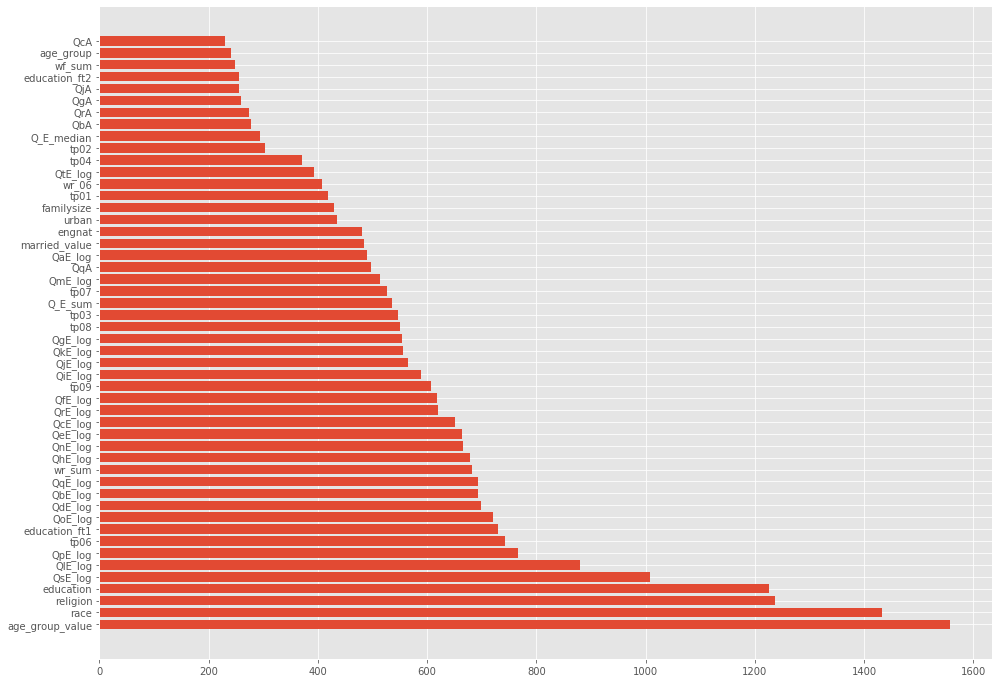

In [439]:
# 모든 변수 포함
ft, test_preds, y_test = validation_model(tr,base_column)

#### LGBM CV

In [465]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [544]:
X_train, X_test, y_train, y_test = train_test_split(
                                tr2,tr['voted'],
                                random_state = 0,
                                test_size = 0.2
                            )

# X_train, X_test, y_train, y_test = train_test_split(
#                                 tr2.drop(columns = 'voted'),tr['voted'],
#                                 random_state = 0,
#                                 test_size = 0.2
#                             )

clf = lgb.LGBMClassifier(n_estimators=1000,
            objective='binary',
            boosting_type='gbdt',
            bagging_fraction = 0.9515683153667026,
            #colsample_bytree = 0.7860120233288207,
            feature_fraction = 0.9362075859090412,
            lambda_l1 = 0.7111030183072032,
            lambda_l2 = 0.5642765168754059,
            learning_rate = 0.011407920284082697,
            max_depth = 6,
            #min_child_weight = 33,
            #num_leaves = 380,
            random_state= 200,
    
    )

param_test ={'num_leaves': [360.380,400], 
             'min_child_weight': [32,33,34],
             'colsample_bytree': [0.75, 0.78, 0.80],}

clf.fit(
            train_x, train_y,
            eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', 
            verbose= 100, 
            early_stopping_rounds=300,
        )

fit_params={"early_stopping_rounds":300, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}


n_HP_points_to_test = 100

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=200,
    verbose=True)

### XGB training

In [411]:
def validation_model_xgb(df,base_column):
    plus_col = list(set(df.columns.tolist()) - set(base_column))
    except_col = list(set(base_column) - set(df.columns.tolist()))
    print(f'추가변수 : {plus_col}')
    print(f'제외변수 : {except_col}')
    
    X_train, X_test, y_train, y_test = train_test_split(
                                df.drop(columns = 'voted'),df['voted'],
                                random_state = 0,
                                test_size = 0.2
                            )

    folds = StratifiedKFold(n_splits=5, shuffle = True)
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    feature_importance = pd.DataFrame()


    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = xgb.XGBClassifier(
            n_estimators=1000,
            objective='binary:logistic',
            booster='gbtree',
            colsample_bytree = 0.7860120233288207,
            learning_rate = 0.011407920284082697,
            max_depth = 7,
            min_child_weight = 33,
            random_state= 200,
        )
    # n_estimators = 1000,base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #               colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
    #               importance_type='gain', interaction_constraints='',
    #               learning_rate=0.7, max_delta_step=0, max_depth=5,
    #               min_child_weight=0.4, monotone_constraints='()', n_jobs=0,
    #               num_parallel_tree=1, objective='binary:logistic', random_state=0,
    #               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
    #               tree_method='exact', validate_parameters=1, verbosity=None
        clf.fit(
            train_x, 
            train_y, 
            eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc',
            verbose= 100, 
            early_stopping_rounds=300
        )

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
        test_preds += clf.predict_proba(X_test)[:,1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_train.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

    ft = feature_importance.groupby('feature')['importance'].mean().reset_index()

    ft2 = ft.sort_values('importance',ascending = False).iloc[:50]

    feature_graph_df = feature_importance.sort_values('importance')
    plt.figure(figsize = (16,12))
    plt.barh(ft2['feature'],ft2['importance'])

    final_score = roc_auc_score(y_test,test_preds)
    print('\n\n')
    print('================================================')
    print(f'\n최종성능: {final_score}\n')
    print('================================================')
    return ft, test_preds, y_test

추가변수 : ['QrE_log', 'QeE_log', 'QmE_log', 'QiE_log', 'QkE_log', 'education_ft1', 'Q_E_sum', 'QgE_log', 'QlE_log', 'QnE_log', 'QjE_log', 'education_ft2', 'wr_wf_mul', 'QdE_log', 'wr_wf_diff', 'wr_wf_sum', 'tp_mean', 'QhE_log', 'married_value', 'QsE_log', 'wf_wf_sum', 'Mach_score', 'QqE_log', 'Q_E_median', 'age_group_value', 'wr_wr_sum', 'wr_sum', 'QcE_log', 'QfE_log', 'QpE_log', 'QaE_log', 'QtE_log', 'tp_median', 'QoE_log', 'wf_sum', 'QbE_log']
제외변수 : ['QqE', 'QnE', 'QcE', 'QrE', 'QkE', 'QaE', 'QgE', 'QpE', 'QhE', 'QdE', 'QsE', 'QtE', 'QoE', 'QiE', 'QmE', 'QfE', 'QjE', 'QeE', 'QbE', 'QlE']
[0]	validation_0-auc:0.76836	validation_1-auc:0.75465
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79517	validation_1-auc:0.76600
[200]	validation_0-auc:0.80601	validation_1-auc:0.76831
[300]	validation_0-auc:0.81650	validation_1-auc:0.76967
[400]	validation_0-auc:0.

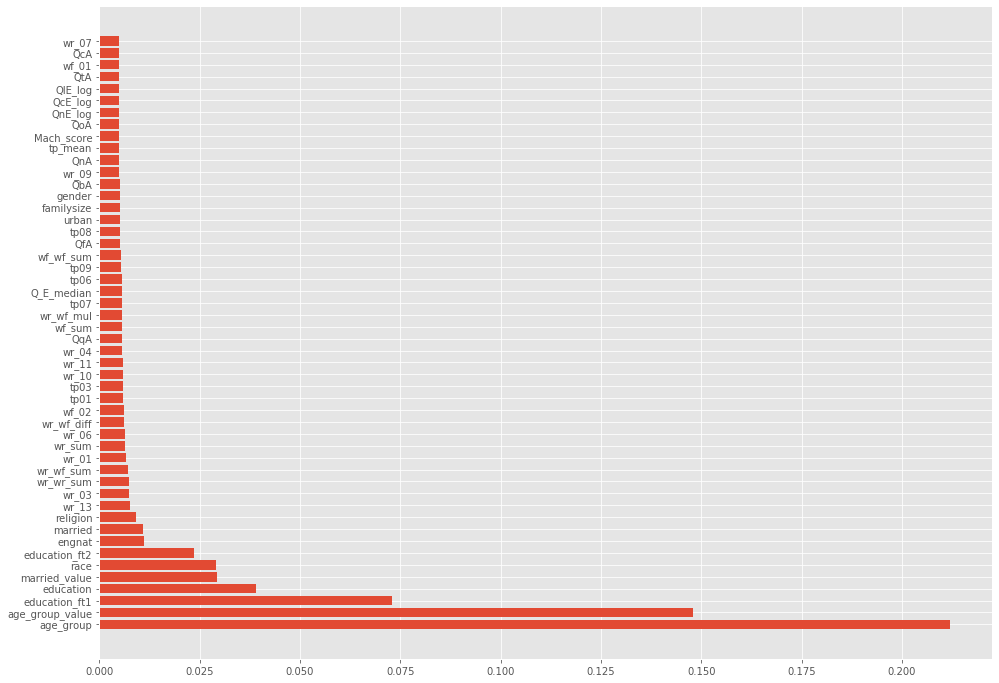

In [419]:
ft, test_preds, y_test = validation_model_xgb(tr,base_column)

### Catboost training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    tr.drop(columns = 'voted'),
    tr['voted'],
    random_state = 0,
    test_size = 0.2
)

  
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=111)
oof_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])
feature_importance = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    clf = cb.CatBoostClassifier(
        n_estimators=1000,
        eval_metric = 'AUC',
    )
    
    
    clf.fit(
        train_x,
        train_y, 
        eval_set = [(train_x, train_y), (valid_x, valid_y)],
        early_stopping_rounds=300,
        verbose= 100
    )
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
    test_preds += clf.predict_proba(X_test)[:,1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
print('최종 성능', roc_auc_score(y_test, test_preds))

### Extra Tree training

### RF training

## Bayesian Optimization

In [431]:
# X = tr.drop(columns = 'voted')
X = tr.drop(columns = ['voted'])
y = tr['voted']

# X_cb = X.fillna(0)
# X_cb = X_cb.replace(np.inf,0)

In [432]:
#목적함수 생성
def lgbm_cv(learning_rate, num_leaves, max_depth, min_child_weight, colsample_bytree, feature_fraction, bagging_fraction, lambda_l1, lambda_l2):
    model = lgb.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = 1000,
                                #boosting = 'dart',
                                num_leaves = int(round(num_leaves)),
                                max_depth = int(round(max_depth)),
                                min_child_weight = int(round(min_child_weight)),
                                colsample_bytree = colsample_bytree,
                                feature_fraction = max(min(feature_fraction, 1), 0),
                                bagging_fraction = max(min(bagging_fraction, 1), 0),
                                lambda_l1 = max(lambda_l1, 0),
                                lambda_l2 = max(lambda_l2, 0)
                               )
    scoring = {'roc_auc_score': make_scorer(roc_auc_score)}
    result = cross_validate(model, X, y, cv=5, scoring=scoring)
    auc_score = result["test_roc_auc_score"].mean()
    return auc_score

# n_estimators=1000,
# objective='binary:logistic',
# booster='gbtree', # gbtree
# colsample_bytree = 0.7860120233288207,
# learning_rate = 0.011407920284082697,#0.011->0.010
# max_depth = 7,
# min_child_weight = 33,
# random_state= 200,
def xgb_cv(learning_rate, gamma, max_depth, min_child_weight, colsample_bytree):
    model = xgb.XGBClassifier(learning_rate=learning_rate,
                                n_estimators = 1000,
                                gamma = gamma,
                                max_depth = int(round(max_depth)),
                                min_child_weight = int(round(min_child_weight)),
                                colsample_bytree = colsample_bytree,
                               )
    scoring = {'roc_auc_score': make_scorer(roc_auc_score)}
    result = cross_validate(model, X, y, cv=5, scoring=scoring)
    auc_score = result["test_roc_auc_score"].mean()
    return auc_score


def cb_cv(learning_rate, num_leaves ,max_depth, min_child_samples, colsample_bylevel):
    model = cb.CatBoostClassifier(learning_rate=learning_rate,
                                n_estimators = 1000,
                                num_leaves = int(round(num_leaves)),
                                max_depth = int(round(max_depth)),
                                min_child_samples = int(round(min_child_samples)),
                                colsample_bylevel = colsample_bylevel,
                               )
    scoring = {'roc_auc_score': make_scorer(roc_auc_score)}
    result = cross_validate(model, X, y, cv=5, scoring=scoring)
    auc_score = result["test_roc_auc_score"].mean()
    return auc_score

In [252]:
pbounds_cb = {'learning_rate' : (0.0001, 0.05),
            'num_leaves': (300, 600),
           'max_depth': (2, 25),
           'min_child_samples': (30, 100),
           'colsample_bylevel': (0, 0.99),
          }

pbounds_xgb = {'learning_rate' : (0.0001, 0.05),
           'gamma': (0, 10),
           'max_depth': (2, 25),
           'min_child_weight': (30, 100),
           'colsample_bytree': (0, 0.99),
          }

pbounds = {'learning_rate' : (0.0001, 0.05),
           'num_leaves': (300, 600),
           'max_depth': (2, 25),
           'min_child_weight': (30, 100),
           'colsample_bytree': (0, 0.99),
           'feature_fraction': (0.0001, 0.99),
           'bagging_fraction': (0.0001, 0.99),
           'lambda_l1' : (0, 0.99),
           'lambda_l2' : (0, 0.99),
          }

In [434]:
lgbmBO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 0 )


In [16]:
xgbBO = BayesianOptimization(f = xgb_cv, pbounds = pbounds_xgb, verbose = 2, random_state = 0 )

In [253]:
cbBO = BayesianOptimization(f = cb_cv, pbounds = pbounds_cb, verbose = 2, random_state = 0 )

In [ ]:
cbBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

In [17]:
xgbBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... |
-------------------------------------------------------------------------------------
|  1        |  0.6958   |  0.5433   |  7.152    |  0.03018  |  14.53    |  59.66    |
|  2        |  0.6871   |  0.6394   |  4.376    |  0.0446   |  24.16    |  56.84    |
|  3        |  0.6911   |  0.7838   |  5.289    |  0.02845  |  23.29    |  34.97    |
|  4        |  0.6914   |  0.08626  |  0.2022   |  0.04165  |  19.9     |  90.9     |
|  5        |  0.6962   |  0.9688   |  7.992    |  0.02313  |  19.95    |  38.28    |
|  6        |  0.6962   |  0.4285   |  4.448    |  0.000560 |  19.61    |  83.41    |
|  7        |  0.6896   |  0.6686   |  2.234    |  0.03724  |  13.25    |  57.16    |
|  8        |  0.6678   |  0.04135  |  0.1809   |  0.005382 |  2.51     |  35.42    |
|  9        |  0.7021   |  0.4595   |  8.958    |  0.01251  |  14.64    |  70.94    |
|  10       |  0.6849   |  0.06196  |  9.931    |  0.0

In [620]:
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7012   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.003645 |  4.004    |  31.42    |  549.8    |
|  2        |  0.6954   |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.03905  |  4.72     |  74.79    |  343.0    |
|  3        |  0.6944   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02286  |  15.07    |  31.32    |  485.3    |
|  4        |  0.6906   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02191  |  18.05    |  34.22    |  500.0    |
|  5        |  0.696    |  0.664    |  0.2083   |  0.1277   |  0.3123   |  0.3601   |  0.02855  |  12.09    |  99.19    |  330.6    |
|  6        |  0.7026   |  0.2069   |  0.1597   |  0.6466   | 

In [275]:
# ver10 데이터로 파라미터 최적화
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6927   |  0.5434   |  0.708    |  0.5968   |  0.5394   |  0.4194   |  0.03233  |  12.06    |  92.42    |  589.1    |
|  2        |  0.7019   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.003645 |  4.004    |  31.42    |  549.8    |
|  3        |  0.6972   |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.03905  |  4.72     |  74.79    |  343.0    |
|  4        |  0.6939   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02286  |  15.07    |  31.32    |  485.3    |
|  5        |  0.6901   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02191  |  18.05    |  34.22    |  500.0    |
|  6        |  0.6946   |  0.4938   |  0.2405   |  0.3419   | 

In [311]:
# 더미화한 데이터로 최적화
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6917   |  0.5434   |  0.708    |  0.5968   |  0.5394   |  0.4194   |  0.03233  |  12.06    |  92.42    |  589.1    |
|  2        |  0.7012   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.003645 |  4.004    |  31.42    |  549.8    |
|  3        |  0.6964   |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.03905  |  4.72     |  74.79    |  343.0    |
|  4        |  0.6937   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02286  |  15.07    |  31.32    |  485.3    |
|  5        |  0.6893   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02191  |  18.05    |  34.22    |  500.0    |
|  6        |  0.7013   |  0.8581   |  0.6215   |  0.3975   | 

In [330]:
# 뉴럴넷 데이터 최적화
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6917   |  0.5434   |  0.708    |  0.5968   |  0.5394   |  0.4194   |  0.03233  |  12.06    |  92.42    |  589.1    |
|  2        |  0.7012   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.003645 |  4.004    |  31.42    |  549.8    |
|  3        |  0.6964   |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.03905  |  4.72     |  74.79    |  343.0    |
|  4        |  0.6937   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02286  |  15.07    |  31.32    |  485.3    |
|  5        |  0.6893   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02191  |  18.05    |  34.22    |  500.0    |
|  6        |  0.7013   |  0.8581   |  0.6215   |  0.3975   | 

In [387]:
# wf02/03 변수 소거
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6929   |  0.5434   |  0.708    |  0.5968   |  0.5394   |  0.4194   |  0.03233  |  12.06    |  92.42    |  589.1    |
|  2        |  0.7014   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.003645 |  4.004    |  31.42    |  549.8    |
|  3        |  0.6962   |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.03905  |  4.72     |  74.79    |  343.0    |
|  4        |  0.6935   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02286  |  15.07    |  31.32    |  485.3    |
|  5        |  0.6896   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02191  |  18.05    |  34.22    |  500.0    |
|  6        |  0.6721   |  0.2326   |  0.05457  |  0.01881  | 

In [427]:
# qe변수 로그화
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  26       |  0.6963   |  0.664    |  0.2083   |  0.1277   |  0.3123   |  0.3601   |  0.02855  |  12.09    |  99.19    |  330.6    |
|  27       |  0.7027   |  0.2069   |  0.1597   |  0.6466   |  0.2508   |  0.4616   |  0.0123   |  5.656    |  37.73    |  496.9    |
|  28       |  0.6979   |  0.1369   |  0.1946   |  0.3651   |  0.8128   |  0.09613  |  0.04191  |  4.21     |  98.35    |  440.6    |
|  29       |  0.7033   |  0.967    |  0.5988   |  0.7319   |  0.0388   |  0.28     |  0.006098 |  8.811    |  38.31    |  395.4    |
|  30       |  0.6997   |  0.4102   |  0.06351  |  0.6856   |  0.5609   |  0.2627   |  0.02621  |  4.161    |  70.32    |  578.8    |
|  31       |  0.7      |  0.2816   |  0.7389   |  0.1498   | 

In [435]:
# qe변수 로그화
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6921   |  0.5434   |  0.708    |  0.5968   |  0.5394   |  0.4194   |  0.03233  |  12.06    |  92.42    |  589.1    |
|  2        |  0.7015   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.003645 |  4.004    |  31.42    |  549.8    |
|  3        |  0.6963   |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.03905  |  4.72     |  74.79    |  343.0    |
|  4        |  0.6932   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02286  |  15.07    |  31.32    |  485.3    |
|  5        |  0.6907   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02191  |  18.05    |  34.22    |  500.0    |
|  6        |  0.6964   |  0.3105   |  0.3619   |  0.1993   | 

In [621]:
lgbmBO.max

{'target': 0.7031378886953144,
 'params': {'bagging_fraction': 0.9669958011996147,
  'colsample_bytree': 0.5987970645475955,
  'feature_fraction': 0.7318970172463788,
  'lambda_l1': 0.03879591433177747,
  'lambda_l2': 0.2799788929506455,
  'learning_rate': 0.006097808404537128,
  'max_depth': 8.811224543009335,
  'min_child_weight': 38.31094032679708,
  'num_leaves': 395.3949538181928}}

In [276]:
# 2
lgbmBO.max

{'target': 0.7053094546762602,
 'params': {'bagging_fraction': 0.3698062073338938,
  'colsample_bytree': 0.07489713711905326,
  'feature_fraction': 0.8218055447768081,
  'lambda_l1': 0.7222964907915178,
  'lambda_l2': 0.8414555963714396,
  'learning_rate': 0.0030925251152918113,
  'max_depth': 7.166751819088359,
  'min_child_weight': 37.3468883586423,
  'num_leaves': 542.2916917720623}}

In [312]:
# 3 - 더미변수
lgbmBO.max

{'target': 0.7025369236368474,
 'params': {'bagging_fraction': 0.8318398041402879,
  'colsample_bytree': 0.9081129401551936,
  'feature_fraction': 0.908742798170918,
  'lambda_l1': 0.3738458812042474,
  'lambda_l2': 0.0990665885840748,
  'learning_rate': 0.0018249414148301688,
  'max_depth': 4.829439057019151,
  'min_child_weight': 36.749144761728466,
  'num_leaves': 561.9676780635398}}

In [388]:
# 4 변수소거 (1)
lgbmBO.max

{'target': 0.7026733374527643,
 'params': {'bagging_fraction': 0.5174586752499394,
  'colsample_bytree': 0.16336591285805346,
  'feature_fraction': 0.6600295087430476,
  'lambda_l1': 0.5045786221433113,
  'lambda_l2': 0.34677843618253623,
  'learning_rate': 0.008679434863557151,
  'max_depth': 5.05906487896959,
  'min_child_weight': 35.46747545288431,
  'num_leaves': 532.5547433920851}}

In [428]:
# 5 변수 로그화
lgbmBO.max

{'target': 0.7032728195590217,
 'params': {'bagging_fraction': 0.9669958011996147,
  'colsample_bytree': 0.5987970645475955,
  'feature_fraction': 0.7318970172463788,
  'lambda_l1': 0.03879591433177747,
  'lambda_l2': 0.2799788929506455,
  'learning_rate': 0.006097808404537128,
  'max_depth': 8.811224543009335,
  'min_child_weight': 38.31094032679708,
  'num_leaves': 395.3949538181928}}

In [436]:
# 5 변수 로그화
lgbmBO.max

{'target': 0.7047802149916288,
 'params': {'bagging_fraction': 0.16026521886490075,
  'colsample_bytree': 0.38230762664460116,
  'feature_fraction': 0.8803127292536881,
  'lambda_l1': 0.6427909607958205,
  'lambda_l2': 0.8516225399539507,
  'learning_rate': 0.004810297234567945,
  'max_depth': 6.072081164468878,
  'min_child_weight': 30.470923513342353,
  'num_leaves': 570.2124396849822}}

In [18]:
xgbBO.max

{'target': 0.702825789561774,
 'params': {'colsample_bytree': 0.6462430788077107,
  'gamma': 1.715971732762962,
  'learning_rate': 0.005504669803513776,
  'max_depth': 13.323358026565089,
  'min_child_weight': 67.7850859645155}}

# Testset inference

## catboost inference

In [256]:
X_train = tr.drop(columns = 'voted')
y_train = tr['voted']
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=111)
oof_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(te.shape[0])
feature_importance = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    clf = cb.CatBoostClassifier(
        n_estimators=1000,
        eval_metric = 'AUC',
    )
    
    
    clf.fit(
        train_x,
        train_y, 
        eval_set = [(train_x, train_y), (valid_x, valid_y)],
        early_stopping_rounds=300,
        verbose= 100
    )
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
    test_preds += clf.predict_proba(te)[:,1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
print('최종 성능', roc_auc_score(y_test, test_preds))

Learning rate set to 0.077015
0:	test: 0.7502038	test1: 0.7366552	best: 0.7366552 (0)	total: 30.3ms	remaining: 30.3s
100:	test: 0.7903615	test1: 0.7564418	best: 0.7564871 (97)	total: 1.96s	remaining: 17.5s
200:	test: 0.8168043	test1: 0.7576411	best: 0.7580132 (158)	total: 3.74s	remaining: 14.9s
300:	test: 0.8419727	test1: 0.7569670	best: 0.7580132 (158)	total: 5.62s	remaining: 13.1s
400:	test: 0.8627617	test1: 0.7563326	best: 0.7580132 (158)	total: 7.4s	remaining: 11s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7580132013
bestIteration = 158

Shrink model to first 159 iterations.
Fold  1 AUC : 0.758013
Learning rate set to 0.077015
0:	test: 0.7477769	test1: 0.7470823	best: 0.7470823 (0)	total: 21.5ms	remaining: 21.5s
100:	test: 0.7887120	test1: 0.7667216	best: 0.7667597 (98)	total: 1.83s	remaining: 16.3s
200:	test: 0.8154533	test1: 0.7673800	best: 0.7678533 (161)	total: 3.75s	remaining: 14.9s
300:	test: 0.8412911	test1: 0.7648169	best: 0.7678533 (161)	total: 5.

ValueError: Found input variables with inconsistent numbers of samples: [9107, 11383]

## inference code

In [472]:
def test_inference(tr, te, model_category):
    
    if model_category == 'lgb':
        X_train = tr.drop(columns = 'voted')
        y_train = tr['voted']

        folds = StratifiedKFold(n_splits=5, shuffle = True)
        test_preds = np.zeros(te.shape[0])
        oof_preds = np.zeros(X_train.shape[0])
        feature_importance = pd.DataFrame()
        
        oof_score = []
        valid_score = []
        
        for n_folds, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

# 베이지안 최적화 1
#  bagging_fraction = 0.9669958011996147,
#                 colsample_bytree = 0.5987970645475955, # 0.78
#                 feature_fraction = 0.7318970172463788,
#                 lambda_l1 = 0.03879591433177747,
#                 lambda_l2 = 0.2799788929506455,
#                 learning_rate = 0.006097808404537128, # 0.011
#                 max_depth = 9,
#                 min_child_weight = 38,
#                 num_leaves = 395,
#                 random_state= 200,

# 베이지안 최적화 2
# {'bagging_fraction': 0.3698062073338938,
#   'colsample_bytree': 0.07489713711905326,
#   'feature_fraction': 0.8218055447768081,
#   'lambda_l1': 0.7222964907915178,
#   'lambda_l2': 0.8414555963714396,
#   'learning_rate': 0.0030925251152918113,
#   'max_depth': 7.166751819088359,
#   'min_child_weight': 37.3468883586423,
#   'num_leaves': 542.2916917720623}

# 기본 파라미터
#  bagging_fraction = 0.9515683153667026,
#                 colsample_bytree = 0.7860120233288207, # 0.78
#                 feature_fraction = 0.9362075859090412,
#                 lambda_l1 = 0.7111030183072032,
#                 lambda_l2 = 0.5642765168754059,
#                 learning_rate = 0.011407920284082697, # 0.011
#                 max_depth = 6,
#                 min_child_weight = 33,
#                 num_leaves = 380,

# qe log 베이지안 최적화
# bagging_fraction = 0.16026521886490075,
# colsample_bytree = 0.38230762664460116,
# feature_fraction = 0.8803127292536881,
# lambda_l1 = 0.6427909607958205,
# lambda_l2 = 0.8516225399539507,
# learning_rate = 0.004810297234567945,
# max_depth = 6,
# min_child_weight = 30,
# num_leaves = 570,

            clf = lgb.LGBMClassifier(
                n_estimators=1000,
                objective='binary',
                boosting_type='gbdt', # gbdt
                bagging_fraction = 0.9669958011996147,
                colsample_bytree = 0.5987970645475955, # 0.78
                feature_fraction = 0.7318970172463788,
                lambda_l1 = 0.03879591433177747,
                lambda_l2 = 0.2799788929506455,
                learning_rate = 0.006097808404537128, # 0.011
                max_depth = 9,
                min_child_weight = 38,
                num_leaves = 395,
                random_state= 200,
                
            )

            clf.fit(
                train_x, train_y,
                eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                eval_metric='auc', 
                verbose= 100, 
                early_stopping_rounds=300
            )
            
            oof_score.append(clf.best_score_['training']['auc'])
            valid_score.append(clf.best_score_['valid_1']['auc'])
            
            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:,1]
            test_preds += clf.predict_proba(te, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits 
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_folds + 1
            feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

            #print('Fold %2d AUC : %.6f' % (n_folds + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        ft = feature_importance.groupby('feature')['importance'].mean().reset_index()
        ft2 = ft.sort_values('importance',ascending = False).iloc[:50]

        feature_graph_df = feature_importance.sort_values('importance')
        plt.figure(figsize = (16,12))
        plt.barh(ft2['feature'],ft2['importance'])

        
        print('tr: ',np.mean(oof_score))
        print('val: ',np.mean(valid_score))
        
        return ft2, test_preds, oof_preds, y_train, oof_score, valid_score
    
    elif model_category == 'xgb':
        X_train = tr.drop(columns = 'voted')
        y_train = tr['voted']

        folds = StratifiedKFold(n_splits=5, shuffle = True)
        test_preds = np.zeros(te.shape[0])
        oof_preds = np.zeros(X_train.shape[0])
        feature_importance = pd.DataFrame()

        for n_folds, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

#             'params': {'colsample_bytree': 0.6462430788077107,
#   'gamma': 1.715971732762962,
#   'learning_rate': 0.005504669803513776,
#   'max_depth': 13.323358026565089,
#   'min_child_weight': 67.7850859645155
            clf = xgb.XGBClassifier(
                n_estimators=1000,
                objective='binary:logistic',
                booster='gbtree', # gbtree
                gamma = 1.715971732762962,
                colsample_bytree = 0.6462430788077107, # 0.7860120233288207,
                learning_rate = 0.005504669803513776,# 0.011407920284082697,
                max_depth = 13, #7,
                min_child_weight = 68, #33,
                random_state= 200,
            )
            
            clf.fit(
                train_x, 
                train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                eval_metric='auc',
                verbose= 100, 
                early_stopping_rounds=300
            )
            
            test_preds += clf.predict_proba(te)[:,1] / folds.n_splits
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_folds + 1
            feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

            #print('Fold %2d AUC : %.6f' % (n_folds + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        ft = feature_importance.groupby('feature')['importance'].mean().reset_index()
        ft2 = ft.sort_values('importance',ascending = False).iloc[:50]

        feature_graph_df = feature_importance.sort_values('importance')
        plt.figure(figsize = (16,12))
        plt.barh(ft2['feature'],ft2['importance'])
        
        return ft2, test_preds, oof_preds, y_train

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.802342	training's binary_logloss: 0.600084	valid_1's auc: 0.772669	valid_1's binary_logloss: 0.60699
[200]	training's auc: 0.812204	training's binary_logloss: 0.560166	valid_1's auc: 0.774465	valid_1's binary_logloss: 0.574623
[300]	training's auc: 0.82041	training's binary_logloss: 0.538527	valid_1's auc: 0.775175	valid_1's binary_logloss: 0.560402
[400]	training's auc: 0.827485	training's binary_logloss: 0.525256	valid_1's auc: 0.775788	valid_1's binary_logloss: 0.553833
[500]	training's auc: 0.834442	training's binary_logloss: 0.515645	valid_1's auc: 0.776252	valid_1's binary_logloss: 0.550847
[600]	training's auc: 0.841495	training's binary_logloss: 0.507878	valid_1's auc: 0.77683	valid_1's binary_logloss: 0.549354
[700]	training's auc: 0.848201	training's binary_logloss: 0.501303	valid_1's auc: 0.77714	valid_1's binary_logloss: 0.548564
[800]	training's auc: 0.854954	training's binary_logloss: 0.

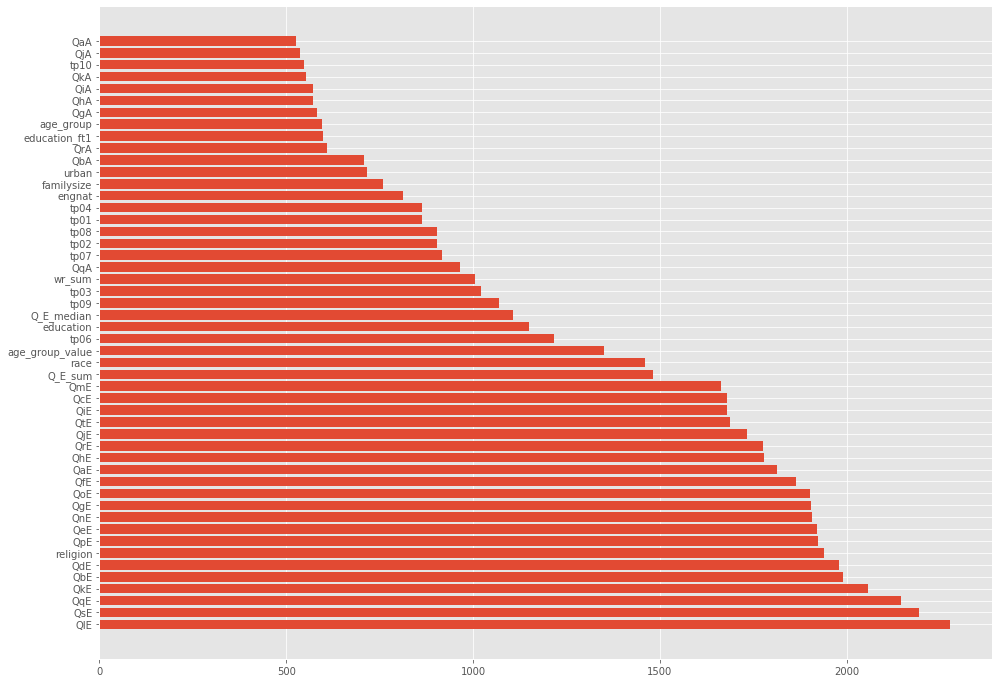

In [7]:
# 제출 43
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'lgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.804402	training's binary_logloss: 0.598742	valid_1's auc: 0.765876	valid_1's binary_logloss: 0.609585
[200]	training's auc: 0.813743	training's binary_logloss: 0.558339	valid_1's auc: 0.767706	valid_1's binary_logloss: 0.579051
[300]	training's auc: 0.822603	training's binary_logloss: 0.536448	valid_1's auc: 0.768694	valid_1's binary_logloss: 0.566355
[400]	training's auc: 0.829142	training's binary_logloss: 0.523503	valid_1's auc: 0.76954	valid_1's binary_logloss: 0.560921
[500]	training's auc: 0.836002	training's binary_logloss: 0.513885	valid_1's auc: 0.769928	valid_1's binary_logloss: 0.558702
[600]	training's auc: 0.843112	training's binary_logloss: 0.505895	valid_1's auc: 0.77001	valid_1's binary_logloss: 0.55783
[700]	training's auc: 0.850027	training's binary_logloss: 0.499059	valid_1's auc: 0.77009	valid_1's binary_logloss: 0.55749
[800]	training's auc: 0.856881	training's binary_logloss: 0.4

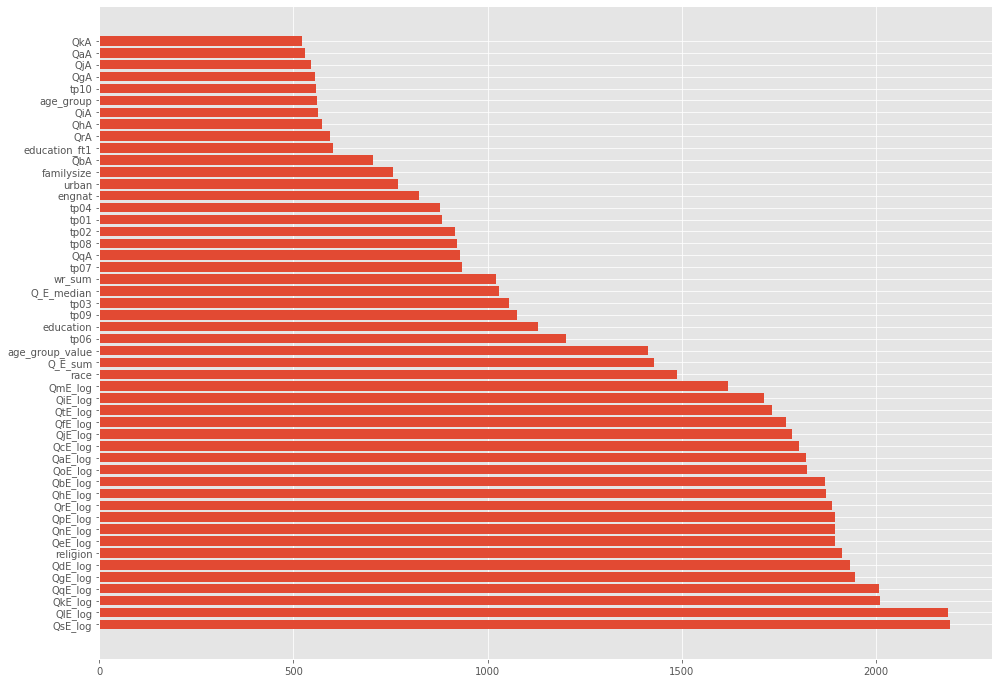

In [409]:
# 제출 51 - 시간변수 로그화
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

# Create Submission

In [505]:
test_preds_lgb_df = pd.read_csv(
    os.path.join(data_file_path,'dacon_submission42.csv')
)

test_preds_lgb2_df = pd.read_csv(
    os.path.join(data_file_path,'dacon_submission55.csv')
)

high_score = pd.read_csv(
    os.path.join(data_file_path,'dacon_submission62.csv')
)

In [260]:
nn_net = pd.read_csv(
    os.path.join(data_file_path,'1110-1254.csv')
)

nn_net['voted'] = nn_net['voted'] - 1

In [87]:
# 0.8 / 0.2이 최적 가중치 앙상블
test_preds = (test_preds_lgb['voted'] * 0.8) + (test_preds_xgb * 0.2)

In [507]:
# 성능 좋았던 0.7814 결과 값 가중치 앙상블
test_preds = (test_preds_lgb_df['voted'] * 0.7) + (test_preds_lgb2_df['voted'] * 0.3)

In [508]:
# 성능 좋았던 0.7814 결과 값 가중치 앙상블
test_preds2 = (high_score['voted'] * 0.8) + (test_preds * 0.2)

In [509]:
# 추론 테스트 코드

# submission['voted'] = test_preds
# submission['voted'] = test_preds_lgb
submission['voted'] = test_preds2
#submission['voted'] = test_preds_xgb

In [510]:
# 제출 버전 기록
n_sub = 67

In [511]:
submission.to_csv(
    os.path.join(data_file_path,'dacon_submission{}.csv'.format(n_sub)
            ),index = False)

In [ ]:
# 28: xgb + lgb 앙상블 -> 0.78029
# 30: 기존 성능이 가장 좋았던 wf_wr_sum까지 한 뒤 kfold rs없이 제출 - index 포험 -> 0.78072
# 31: 마찬가지로 rs없이 제출 - index 포함x -> 0.78038
# 32: 0.78054 -> qe 데이터 로그화
# 33: -> 0.7788.... tp, wr 클러스터링 변수 생성 개떡락
# 34: -> ver9 데이터에 objective=dart로 변환
# 37: object 컬럼 카테고리컬 컬럼으로 변경해서 시행
# 38: colsample 0.70
# 가중치 0.7,0.3 성능이 가장 좋음 59
# 63: 0.75, 0.25 가중치
# 64: log에 베이지안 최적화 -> 성능 개떡락

# weight ensemble(가중치 최적화)

https://dacon.io/competitions/official/235573/codeshare/697#CATBOOST

In [ ]:
# 가중치 산출은 일반 데이터가지고 산출하면 좋을듯